In [3]:
import pandas as pd
DATASET = "sentiment_ds.csv"
import logging
import warnings
import sys
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
logging.disable(sys.maxsize)



In [4]:
ds = pd.read_csv(DATASET, error_bad_lines=False, header=0, warn_bad_lines=False) 
# there are some malformed entries the dataset... let's ignore those for now


In [5]:
len(ds.index)

2393238

In [12]:
#lots of nan values... :( 
ds.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating          22
helpful_votes        23
total_votes          23
vine                 23
verified_purchase    23
review_headline      34
review_body          88
review_date          65
dtype: int64

In [9]:
# Counts of reviews for same product
ds['product_id'].value_counts()

B00DS842HS    9998
B007Y59HVM    4526
B00M2OGS08    3881
B007TGDXMU    3691
B0029XDZIK    3461
              ... 
B004JRMFYE       1
B000MOF2XO       1
B00B72LCK2       1
B00GHLVCXA       1
B00BH8HR00       1
Name: product_id, Length: 305018, dtype: int64

In [10]:
# Counts of reviews with same body
ds['review_body'].value_counts().nlargest(20)

Great             3592
good              3479
great             2913
Good              2728
Delicious!        2188
Excellent         1949
Delicious         1822
very good         1449
Great!            1431
Love it           1428
Yummy             1413
Very good         1397
love it           1320
ok                1307
Great product     1215
excellent         1013
Love it!          1006
Great product!     959
Yummy!             958
yummy              926
Name: review_body, dtype: int64

In [11]:
# Counts of reviews with same headline
ds['review_headline'].value_counts()

Five Stars                                                  335872
Four Stars                                                   46678
Three Stars                                                  22617
One Star                                                     19799
Two Stars                                                    12316
                                                             ...  
Love Boyds coffee                                                1
Back to nature classic cream cookies                             1
thanksgiving in a bar!                                           1
Great for making your own salt and vinegar items at home         1
Good Popcorn, but.....                                           1
Name: review_headline, Length: 1269495, dtype: int64

In [12]:
# Lots of spammy duplicate reviews...might be worth checking if the same person is duplicating the reviews across multiple products
x = ds[ds['review_body'].duplicated() == False]
x.head()
print(len(x.index))

2218165


In [27]:
ds = ds[ds['review_body'].duplicated() == False]

In [13]:
#remove NaNs from the dataset  for now...
ds = ds.dropna()

In [14]:
ds["n_reviews"] = ds.groupby('product_id')['product_id'].transform('count')

In [55]:
#nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def sentiment_heuristic(row):
    return sia.polarity_scores(row)['compound']


In [67]:
sia.polarity_scores("death")['compound']

-0.5994

In [18]:
# This will take ages to run lol
#dataset['sentiment_score'] = dataset["review_body"].apply(sentiment_heuristic)

In [16]:

def filter_bad_star(row):
    '''
    determine if a row is a negative review based on its score. Potentially extend it to include sentiment analysis 
    and presence of specific negative words 
    '''
    return row["star_rating"].astype(int) <=3

def filter_good_star(row):
    '''
    determine if a row is a positive review based on its score.
    '''
    return row["star_rating"].astype(int) > 3

In [17]:
negative_rows = ds.loc[filter_bad_star]
negative_rows.head()
len(negative_rows.index)

445115

In [18]:
positive_rows = ds.loc[filter_good_star]
positive_rows.head()
len(positive_rows.index)

1948123

In [31]:
negative_rows.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,n_reviews
5,US,23649464,RIG9AWFOGRDVO,B00AL6QBZ6,681475449,Herr's Popcorn Hot Cheese 1 Oz (Pack of 30),Grocery,2,1.0,1.0,N,Y,Not Happy,The popcorn was stale.,2015-08-31,8
9,US,19624355,R1ODXB3C9UP3NL,B00J074W94,2499702,"Orgain Organic Plant Based Protein Powder, Pac...",Grocery,1,1.0,3.0,N,N,Disgusting now and difficult on digestion,Used to be a decent product. Disgusting now a...,2015-08-31,522
17,US,22765168,R3T6TTD2IN0EFZ,B00XDXMLL2,971154239,"Skippy Creamy Peanut Butter, with Salted Caram...",Grocery,1,4.0,4.0,N,N,"1 Out Of 5 Of My Co-Workers Thought It Was ""Okay""",I bought this from a local super market on a w...,2015-08-31,6
23,US,35636887,R9MISLBRG08FX,B00DBSFXUA,294404974,"Keebler Town House Pita Crackers, 9.5 Ounce",Grocery,1,0.0,0.0,N,Y,pita crackers,not craze about these. nothing really wrong wi...,2015-08-31,107
26,US,12650237,R2A9O8CWZ1PP74,B0083GJKR2,868929824,"Eclipse Sugar Free Gum, Spearmint, 120 Piece B...",Grocery,3,0.0,0.0,N,Y,Three Stars,it's gum..,2015-08-31,25


In [223]:
positive_rows = ds.loc[filter_good_star]
positive_rows.head()
len(positive_rows.index)

1948123

In [45]:
bad_words = [
    "stinky",
    "stank"
    "moldy",
    "mouldy",
    "rotted",
    "rotten",
    "stale"
    "stinking",
    "icky",
    "curdled",
    "danger",
    "dangerous",
    "ammonia",
    "unsafe",
    "avoid",
    "sick",
    "ill"
]

# How do we account for spelling mistakes? Do we need to?

def filter_bad_words(row):
    '''
    determine if a row is a negative review based on its words.
    '''
    return row["review_headline"].str.contains("\\b(%s)\\b" % '|'.join(bad_words))


In [46]:
bad_words_rows = negative_rows.loc[filter_bad_words]
len(bad_words_rows.index)

852

In [50]:
bad_words_rows['sentiment_score'] = bad_words_rows["review_body"].apply(sentiment_heuristic)

In [51]:
bad_words_rows.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,n_reviews,sentiment_score
6771,US,13291352,R1CUESPVBEPW5O,B006PN9K20,194575117,Banana Yellow Gourmet Salt Water Taffy 1 Pound...,Grocery,1,0.0,0.0,N,N,avoid this style!,"I got this by mistake, somehow. there seems t...",2015-08-29,14,0.7263
8911,US,37307498,RZP5EWKOBX5KH,B009L9TMBY,696947556,"Deluxe Mixed Nuts Raw, 2Lbs",Grocery,2,1.0,1.0,N,Y,Ixnay on the rotten nuts.,"Probably would have been good, but my nuts wer...",2015-08-28,20,-0.7750
12033,US,16713356,R3TJAA4Z41IHXE,B00D4GVY1Q,358382489,Plum Organics Little Yums Teething Wafers,Grocery,1,2.0,3.0,N,Y,Made my baby sick,"I was happy with these at first, but my 10 mon...",2015-08-27,22,0.0174
17431,US,13614526,R3VZ726SRT2PU7,B00C6817HY,951776824,"Vegemite 220g - Two Pack, with Amazon Prime, A...",Grocery,1,0.0,5.0,N,Y,Made me sick,This Vegemite made me very ill. I broke out in...,2015-08-25,77,-0.5698
20978,US,23633301,R3GUP8V2Y1PNIH,B00BJ9UJ7U,565850617,Starbucks Decaf Pike Place Roast K-Cup for Keu...,Grocery,1,0.0,3.0,N,Y,I am so sick of the horrible ingredients in St...,Starbucks uses the paint stripper solvent Meth...,2015-08-24,113,-0.9730


In [22]:
bad_sentiment_rows = ds[ds['sentiment_score'] < 0]

In [23]:
len(bad_sentiment_rows.index)

243594

In [55]:
bad_sentiment_rows["n_bad_reviews"] = bad_sentiment_rows.groupby('product_id')['product_id'].transform('count')
bad_sentiment_rows["bad_review_percent"] = bad_sentiment_rows["n_bad_reviews"] / negative_rows["n_reviews"]

In [56]:
bad_sentiment_rows.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,n_reviews,sentiment_score,n_bad_reviews,bad_review_percent
8911,US,37307498,RZP5EWKOBX5KH,B009L9TMBY,696947556,"Deluxe Mixed Nuts Raw, 2Lbs",Grocery,2,1.0,1.0,N,Y,Ixnay on the rotten nuts.,"Probably would have been good, but my nuts wer...",2015-08-28,20,-0.7750,1,0.050000
17431,US,13614526,R3VZ726SRT2PU7,B00C6817HY,951776824,"Vegemite 220g - Two Pack, with Amazon Prime, A...",Grocery,1,0.0,5.0,N,Y,Made me sick,This Vegemite made me very ill. I broke out in...,2015-08-25,77,-0.5698,1,0.012987
20978,US,23633301,R3GUP8V2Y1PNIH,B00BJ9UJ7U,565850617,Starbucks Decaf Pike Place Roast K-Cup for Keu...,Grocery,1,0.0,3.0,N,Y,I am so sick of the horrible ingredients in St...,Starbucks uses the paint stripper solvent Meth...,2015-08-24,113,-0.9730,1,0.008850
22258,US,47973491,R1NOLST0E8IATT,B0036ZIF9Y,923729241,Gemlik Type Black Olives LUX – 1.1lb (500g),Grocery,1,2.0,2.0,N,Y,Mine were rotten and tasted horrible...,I am Turkish and I've never had any problems w...,2015-08-24,7,-0.9069,1,0.142857
35555,US,30293525,R1FRDE0OIA546B,B00TCOAXR0,915238907,Chung Jung One Anchovy Sauce Blue,Grocery,1,3.0,9.0,N,Y,.It tastes like it was made with rotted anchov...,The taste is okay....Nothing spectacular....It...,2015-08-19,3,-0.0772,1,0.333333


In [57]:
# Reviews sorted by proportion of reviews that are 'bad'
sorted = bad_sentiment_rows.sort_values(by=['bad_review_percent', 'n_reviews'], ascending=False)

In [6]:
bs_gs = ds[ds["sentiment_score"] > 0]
bs_gs = bs_gs[bs_gs["star_rating"] <= 2]
print(len(bs_gs.index))

127228


In [68]:
ds_ns = ds[ds["sentiment_score"] < 0]

In [70]:
ds_2s = ds[ds["star_rating"] <= 2]

In [71]:
print(len(ds_2s.index))

284281


In [69]:
print(len(ds_ns.index))

243594


In [74]:
ds_gs = ds[ds["sentiment_score"] < 0]
ds_gs = ds_gs[ds_gs["star_rating"] >= 4]

In [75]:
print(len(ds_gs.index))

76378


In [8]:
ds_gs = ds[ds["sentiment_score"] == 0]
ds_gs = ds_gs[ds_gs["star_rating"] <= 2]

In [10]:
print(len(ds_gs.index))

26244


In [12]:
ds_gs[["product_id", "review_date", "sentiment_score", "star_rating", "review_headline", "review_body"]].sample(n=10)

,product_id,review_date,sentiment_score,star_rating,review_headline,review_body
508704,B0092VRBW8,2015-03-09,0.0,1.0,One Star,I thought this was a non alcoholic extract but...
459261,B001Q51RU0,2015-03-25,0.0,1.0,One Star,Had to send it back because it contains aspart...
2046886,B0071IWSVI,2012-04-22,0.0,1.0,Why?,"Why would you buy this product here, when its ..."
731935,B00EDU860E,2015-01-01,0.0,2.0,Timely shipping but one candy cane was partial...,Timely shipping but one candy cane was partial...
645790,B0033TYF2E,2015-01-27,0.0,2.0,Two Stars,I would buy these if they weren't made with ag...
603522,B0009PEX22,2015-02-11,0.0,2.0,Two Stars,not what i expected the flavor to be.
186794,B004VLV6ES,2015-06-27,0.0,1.0,not non-GMO anymore,"not non-GMO anymore<br />packaging changed, fa..."
32480,B00QTKSWVE,2015-08-20,0.0,1.0,Weird taste!,Unique taste that I couldn't get used to.
1374223,B0049VPI58,2014-02-17,0.0,1.0,Seeds never grew,"I bought this product 3 months ago, planted th..."
882642,B00ANO5INW,2014-11-06,0.0,1.0,One Star,Organic but taste ucks


In [37]:
pd.set_option('display.max_colwidth', None)

In [81]:
bs_gs[["product_id", "review_date", "sentiment_score", "star_rating", "review_body"]].sample(n=10)

,product_id,review_date,sentiment_score,star_rating,review_body
2148307,B004S5ZZBW,2011-08-01,0.2500,1.0,The title says it all. Product had the consistency and flavor of sawdust. If you imagine taking a pinch of sawdust and stirring in black pepper you have just created the equivalent of Wild Bills Black Pepper Chew
500399,B00H3S2BHC,2015-03-12,0.6467,2.0,"I was excited to try this taking from all the good reviews. After opening it and made my first cup, I was disappointed. This is a very MILD coffee!! Not the medium roast I expected. It is smooth, though, so I'll give 2 stars for that. Get them if you like mild, water-down coffee."
388246,B00HV85EUA,2015-04-17,0.2844,2.0,It just doesn't taste like the powder. I'm not sure how to explain it. Oregon chai is my favorite Chai tea but not in the<br />K-cup. I can't find any K-cup tea that I like. There is always a funny taste when I drink it.
850015,B00122E5SS,2014-11-20,0.5704,2.0,"I have eaten smoked salmon all my life. I don't know what this is, but it tastes more like BBQ tuna."
1353361,B0051WBSFI,2014-02-28,0.4404,2.0,More than 3/4 of the kernels did not pop.<br />It had a good taste.<br />I will not buy it again.
2101775,B001EO5S58,2011-12-16,0.3683,1.0,Never liked regular breakfast bars when I tried them because the filling was so sweet. These bars follow in the footsteps of regular ones. The surrounding pastry was tasty though.
2012973,B004TVRUX6,2012-07-20,0.5318,1.0,This stuff has absolutely zero olive oil taste or smell. I might as well have bought bottles of Wesson for 1/4 the price. Don't waste your money.
1875518,B009EDU77A,2013-01-25,0.9100,2.0,"I love Biscoff cookies, and ginger snap cookies in general. But there is just something missing from this spread. It is too sugary with not enough spice. It tastes like canned cake frosting actually. When just eating a spoonful by itself I can taste a bit of biscoff flavor, however when spreading it on anything else, like a graham cracker, it just tastes like sweet frosting, with whatever it is spread on over powering."
1726212,B00BYNDPNG,2013-05-28,0.1885,1.0,"For a company that prides themselves on being \\""Made from the best stuff on earth\\"" This product is loaded with artificial sweeteners. I was quite upset and alarmed to notice the high % of aspartame in this which is widely accepted as one of the most carcinogenic artificial sweeteners. I will not be purchasing this product again."
255727,B00DOAH6G4,2015-06-02,0.3612,2.0,Tasted like garbage and very small


In [58]:
bad_sentiment_rows['product_id'].value_counts()
bad_sentiment_rows['product_parent'].value_counts()

162663470    8
985687682    6
792561286    5
409319444    4
629757706    4
            ..
660478303    1
186958080    1
671176027    1
219289946    1
354284543    1
Name: product_parent, Length: 485, dtype: int64

In [19]:
bad_words_rows.plot.kde(y='sentiment_score')

NameError: name 'bad_words_rows' is not defined

<AxesSubplot:ylabel='Density'>

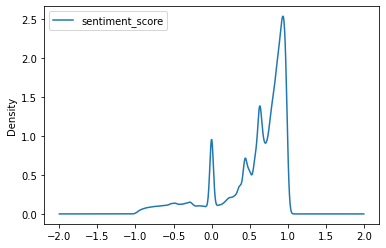

In [24]:
ds.plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

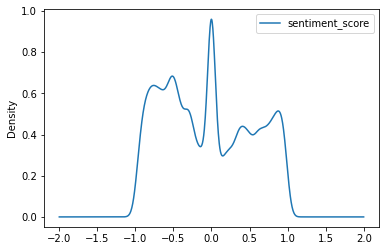

In [29]:
ds[ds["star_rating"] == 1].plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

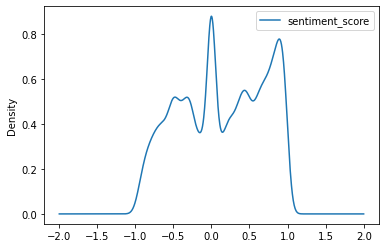

In [30]:
ds[ds["star_rating"] == 2].plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

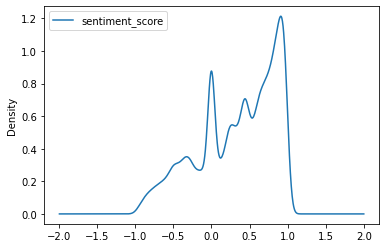

In [27]:
ds[ds["star_rating"] == 3].plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

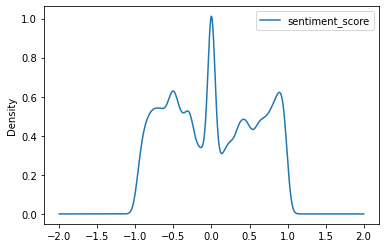

In [31]:
ds[ds["star_rating"] <= 2].plot.kde(y='sentiment_score')

In [32]:
ds["star_rating"].astype(int).corr(ds["sentiment_score"].astype(float))

0.5052050919979766

In [68]:
bad_words_rows.to_csv('bad-reviews.csv', index = False, header=True)

FileNotFoundError: [Errno 2] No such file or directory: ''